In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
df=pd.read_excel('/Users/tobiaspottier/Main/Schoo/IndustryProject/Bariatric Project Study Data 202505.xlsx', sheet_name='Sheet1')

In [3]:
df = df.dropna(subset=['weight.4'])

import re

# After you’ve done df = df.dropna(subset=['weight.4']), when building cm_cols:

# 1) Select only columns that start with “CM_” and do NOT end with “.<digits>”
cm_cols = [
    col
    for col in df.columns
    if col.startswith('CM_') and not re.search(r"\.\d+$", col)
]

# Now cm_cols contains only the “base” CM_ columns (no .1, .2, etc.)
print("Selected CM_ columns (no suffix):", cm_cols)

# 2) Build cm_data as before
cm_data = df[cm_cols].fillna(0).astype(int)

# 3) Drop any all-zero columns among these
zero_only = [c for c in cm_data.columns if (cm_data[c] == 0).all()]
cm_data = cm_data.drop(columns=zero_only)

# 4) Join back into core_X_data
core_X_data = df[[
    'gender', 'age', 'height', 'weight', 'bmi',
    'family_hist_cnt', 'chronic_meds_cnt',
    'procedure_category', 'antibiotics'
]].copy()
core_X_data = core_X_data.join(cm_data)
core_X_data.fillna(0, inplace=True)

# Check that no CM_ columns ending in .1 or .2 remain:
print(core_X_data.isna().sum())
print("Dropped CM columns:", zero_only)
print("Remaining CM columns:", cm_data.columns.tolist())

# (…then your antibiotic‐dummy logic as before…)
ab_cols = [c for c in core_X_data.columns if c.startswith('antibiotics')]
for col in ab_cols:
    n_zeros = (core_X_data[col] == 0).sum()
    print(f"{col}: {n_zeros} zeros out of {len(core_X_data)} rows")

no_ab_rows = (core_X_data[ab_cols].sum(axis=1) == 0).sum()
print(f"\nRows where ALL antibiotic dummies are 0: {no_ab_rows}")
core_X_data.shape
for col in core_X_data.columns:
    print(col)



Selected CM_ columns (no suffix): ['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_SMOKE', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD']
gender                0
age                   0
height                0
weight                0
bmi                   0
family_hist_cnt       0
chronic_meds_cnt      0
procedure_category    0
antibiotics           0
CM_AIDS               0
CM_DEPRESS            0
CM_DM                 0
CM_DMCX               0
CM_HTN_C              0
CM_HYPOTHY            0
CM_LIVER              0
CM_OBESE              0
CM_SMOKE              0
CM_APNEA              0
CM_CHOLSTRL           0
CM_OSTARTH            0
CM_HPLD               0
dtype: int64

In [4]:
core_X_data.shape

(86, 22)

In [5]:

df_weight_12_months= df["weight.4"]
df_weight_pre_op=df["weight"]
df['weight_loss_percentage'] = df['weight'] - df['weight.4'] /df['weight'] *100
df_weight_loss_total= df['weight_loss_percentage']



df_weight_pre_op.head(10)


5     115.0
7     131.0
10    160.0
13    144.8
18    155.0
21    107.0
30    124.0
38    133.0
49     98.0
55    107.0
Name: weight, dtype: float64

In [6]:
# Check whether CM_NEURO survived the filtering
if 'CM_CHF' in core_X_data.columns:
    print("CM_CHF is present in core_X_data!")
else:
    
    print("CM_CHFis NOT in core_X_data.")
if 'CM_DM' in core_X_data.columns:
    print("CM_NEURO is present in core_X_data!")
else:
    print("CM_NEURO is NOT in core_X_data.")

CM_CHFis NOT in core_X_data.
CM_NEURO is present in core_X_data!


In [7]:
# Missing values analysis
missing_df = pd.DataFrame({
    'Missing_Count': core_X_data.isnull().sum(),
    'Missing_Percentage': (core_X_data.isnull().sum() / len(core_X_data)) * 100
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)
print(f"Columns with missing values: {len(missing_df)}/{core_X_data.shape[1]}")
print(f"Total completeness: {(1 - core_X_data.isnull().sum().sum()/(core_X_data.shape[0]*core_X_data.shape[1]))*100:.1f}%")

if len(missing_df) > 0:
    print("\nTop missing columns:")
    print(missing_df.head(10))
    
    # Visualization
    plt.figure(figsize=(10, 6))
    top_missing = missing_df.head(15)
    plt.barh(range(len(top_missing)), top_missing['Missing_Percentage'], color='coral')
    plt.yticks(range(len(top_missing)), top_missing.index)
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 15 Columns with Missing Values', fontsize=14, fontweight='bold')
    
    for i, v in enumerate(top_missing['Missing_Percentage']):
        plt.text(v + 0.1, i, f'{v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found!")

MISSING VALUES ANALYSIS
Columns with missing values: 0/22
Total completeness: 100.0%
No missing values found!


In [8]:
core_Y_data=df[['weight_loss_percentage']]

core_Y_data.head(10)

,weight_loss_percentage
5,45.434783
7,64.587786
10,90.000000
13,58.474033
18,91.774194
21,48.214953
30,40.935484
38,49.541353
49,22.489796
55,37.186916


Training samples: 68, Test samples: 18

Linear Regression on Test Set:
  R²   = 0.860
  MAE  = 7.217  (percentage points)
  RMSE = 8.988 (percentage points)

5-Fold CV (averaged):
  R²   = 0.775
  MAE  = 6.767 (percentage points)
  RMSE = 8.434 (percentage points)



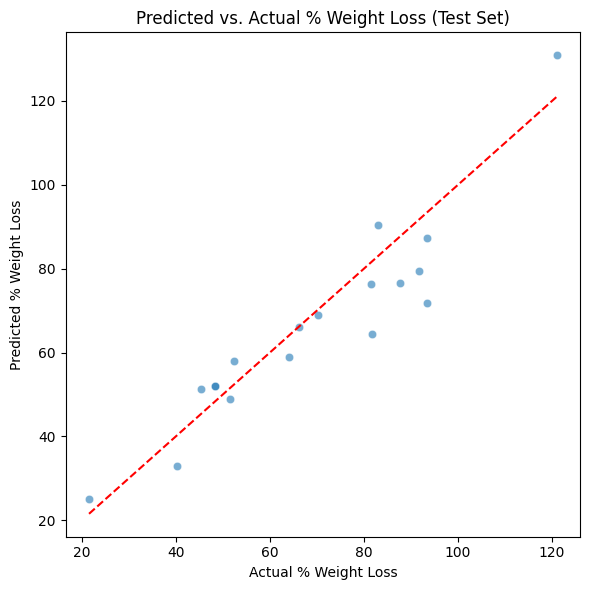

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Prepare data
X = core_X_data.copy()
y = core_Y_data['weight_loss_percentage'].values

# 2) One-hot encode any categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 3) Split into train/test (no stratify, since y is continuous)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(y_train)}, Test samples: {len(y_test)}\n")

# 4) Build a pipeline: scaler → linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# 5) Fit on training data
pipeline.fit(X_train, y_train)

# 6) Predict on test set
y_pred = pipeline.predict(X_test)

# 7) Evaluate regression performance
mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print("Linear Regression on Test Set:")
print(f"  R²   = {r2:.3f}")
print(f"  MAE  = {mae:.3f}  (percentage points)")
print(f"  RMSE = {rmse:.3f} (percentage points)\n")

# 8) (Optional) 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae  = -cross_val_score(pipeline, X_encoded, y, cv=kf,
                           scoring='neg_mean_absolute_error').mean()
cv_rmse = (-cross_val_score(pipeline, X_encoded, y, cv=kf,
                            scoring='neg_mean_squared_error').mean()) ** 0.5
cv_r2   = cross_val_score(pipeline, X_encoded, y, cv=kf, scoring='r2').mean()

print("5-Fold CV (averaged):")
print(f"  R²   = {cv_r2:.3f}")
print(f"  MAE  = {cv_mae:.3f} (percentage points)")
print(f"  RMSE = {cv_rmse:.3f} (percentage points)\n")

# 9) (Optional) Plot predicted vs. actual % weight loss
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual % Weight Loss")
plt.ylabel("Predicted % Weight Loss")
plt.title("Predicted vs. Actual % Weight Loss (Test Set)")
plt.tight_layout()
plt.show()


Training samples: 68, Test samples: 18

Lasso Regression on Test Set:
  R²   = 0.863
  MAE  = 6.819  (percentage points)
  RMSE = 8.900 (percentage points)

5-Fold CV (averaged):
  R²   = 0.849
  MAE  = 5.838 (percentage points)
  RMSE = 7.492 (percentage points)



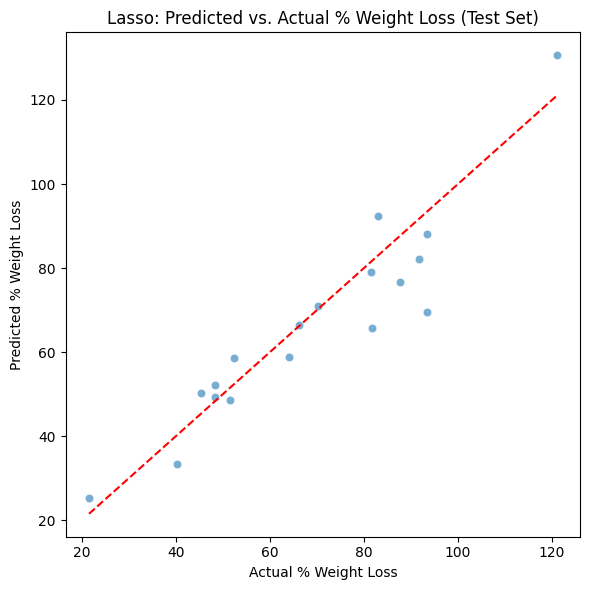

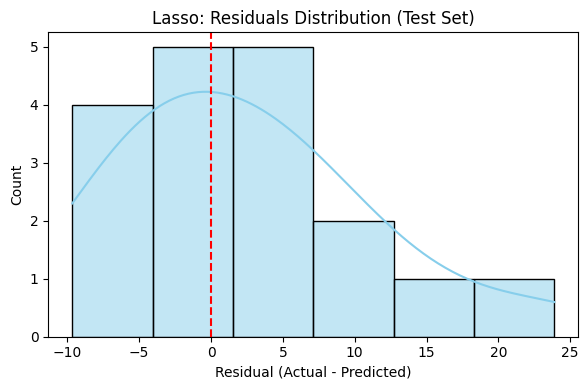

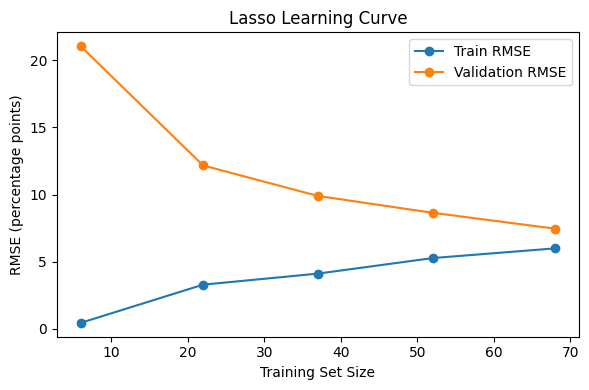

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1) Prepare data
X = core_X_data.copy()
y = core_Y_data['weight_loss_percentage'].values

# 2) One-hot encode any categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 3) Split into train/test (no stratify, since y is continuous)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(y_train)}, Test samples: {len(y_test)}\n")

# 4) Build a pipeline: scaler → Lasso regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1, max_iter=90000, random_state=42))
])

# 5) Fit on training data
pipeline.fit(X_train, y_train)

# 6) Predict on test set
y_pred = pipeline.predict(X_test)

# 7) Evaluate regression performance
mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print("Lasso Regression on Test Set:")
print(f"  R²   = {r2:.3f}")
print(f"  MAE  = {mae:.3f}  (percentage points)")
print(f"  RMSE = {rmse:.3f} (percentage points)\n")

# 8) 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae  = -cross_val_score(pipeline, X_encoded, y, cv=kf,
                           scoring='neg_mean_absolute_error').mean()
cv_rmse = (-cross_val_score(pipeline, X_encoded, y, cv=kf,
                            scoring='neg_mean_squared_error').mean()) ** 0.5
cv_r2   = cross_val_score(pipeline, X_encoded, y, cv=kf, scoring='r2').mean()

print("5-Fold CV (averaged):")
print(f"  R²   = {cv_r2:.3f}")
print(f"  MAE  = {cv_mae:.3f} (percentage points)")
print(f"  RMSE = {cv_rmse:.3f} (percentage points)\n")

# 9) Plot predicted vs. actual % weight loss (Test Set)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual % Weight Loss")
plt.ylabel("Predicted % Weight Loss")
plt.title("Lasso: Predicted vs. Actual % Weight Loss (Test Set)")
plt.tight_layout()
plt.show()

# 10) Plot residuals histogram (Test Set)
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Lasso: Residuals Distribution (Test Set)")
plt.tight_layout()
plt.show()

# 11) Plot learning curve for train vs. validation error (Optional)
train_sizes, train_scores, val_scores = learning_curve(
    pipeline, X_encoded, y, cv=kf,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_rmse, marker='o', label='Train RMSE')
plt.plot(train_sizes, val_rmse, marker='o', label='Validation RMSE')
plt.xlabel("Training Set Size")
plt.ylabel("RMSE (percentage points)")
plt.title("Lasso Learning Curve")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
import joblib

# Save model
joblib.dump(pipeline, 'weight_loss_pipeline.pkl')

# Later: Load model
loaded_model = joblib.load('weight_loss_pipeline.pkl')

In [12]:
new_prediction = loaded_model.predict(new_encoded_input)

NameError: name 'new_encoded_input' is not defined

In [17]:
for col in X_encoded.columns:
    print(f"{col}: {X_encoded[col].values[0]}")

age: 23
height: 163
weight: 115.0
bmi: 43.28
family_hist_cnt: 0
chronic_meds_cnt: 0
CM_AIDS: 0
CM_DEPRESS: 0
CM_DM: 0
CM_DMCX: 0
CM_HTN_C: 0
CM_HYPOTHY: 0
CM_LIVER: 0
CM_OBESE: 0
CM_SMOKE: 0
CM_APNEA: 0
CM_CHOLSTRL: 0
CM_OSTARTH: 0
CM_HPLD: 0
gender_Male: False
procedure_category_Mini gastric bypass (OAGB): False
procedure_category_RYGBP: False
procedure_category_SADI: True
procedure_category_Sleeve: False
antibiotics_Augmentin: False
antibiotics_Clindamycin: False
antibiotics_Invanz: False
antibiotics_Kefsol: True


In [ ]:
x_